# Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [10]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

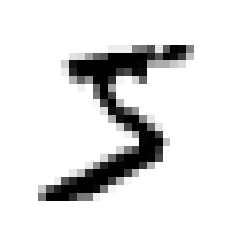

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [14]:
y[0]

'5'

Cast the label to a int

In [15]:
import numpy as np
y = y.astype(np.uint8)

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**SGD**: Stochasthic Gradient Descent Classifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(n_jobs=-1, random_state=42)

In [13]:
sgd_clf = SGDClassifier(random_state=42, n_jobs=8)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(n_jobs=8, random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
correct_prediction =  sgd_clf.predict(X_test) == (y_test_5)
len(list(filter(lambda x: not x, correct_prediction))) / len(list(correct_prediction)) * 100

5.08

## Performance Measures
Evaluating a **classifier** is trickier than evaluating a regressor.

### Measuring Accuracy Using Stratified K Cross-Validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
from sklearn.base import BaseEstimator

class NeverFiveClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

never_five_clf = NeverFiveClassifier()
cross_val_score(never_five_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That demonstrates that **skewed datasets** attempts to confuse our machine learning classifier accuracy.

### Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

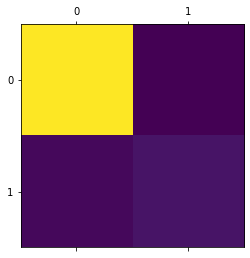

In [20]:
conf_mx_5 = confusion_matrix(y_train_5, y_train_pred)
plt.matshow(conf_mx_5)
plt.show()

In [19]:
# non-5 images (true negatives), predicted 5 (false positives FP)
# classified as non-5 but are 5(false negatives FN), predicted 5 correctly (true positives TP)

$$precision = \frac{TP}{TP + FP}$$

With one *single positive prediction* and ensure it is correct, we would have 100% precision, but we don't know if the classifier would ignore all but one positive instances.
So presicion is used along with another metric called **recall**  or sensitivity or true positive rate (TPR).
$$recall = \frac{TP}{TP + FN}$$

### Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

Of all 5 predictions, **83.7%** are correct.

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It detects **65% of correct fives**

It is often convenient to mix precision and recall into one single metric called $F_1 score$, which is the **harmonic mean of precision and recall**:


$$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision+recall}
= \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

Scikit-Learn does not let you set the threshold directly, but it does give you access to the **decision scores that it uses to make predictions**. Instead of calling the classifier's *predict()* method, you can call its decision_fuction method. while returns an score for each instance, and then use any threshold you want to make prections based on thos scores.

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

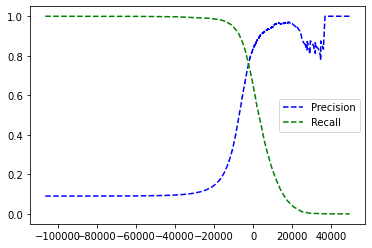

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [30]:
threshold_90_precision

3370.019499143957

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [32]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

The **reciever operating characteristic (*ROC*)** curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the **true positive rate (recall) (TPR)** against the **false positive rate (FPR)**.

The **false positive rate (FPR)** is the ratio of negative instances that are incorrectly classified as positive. Cuantes instancies classificades com positiu són falses.

$$FPR = 1 - TNR$$
**TNR** is the ratio of negative instances that are correctly classified as negative (**specificity**). *ROC* curve plots *sensitivity* (recall) versus *1 - specifity*.

In [35]:
from sklearn.metrics import roc_curve

In [36]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

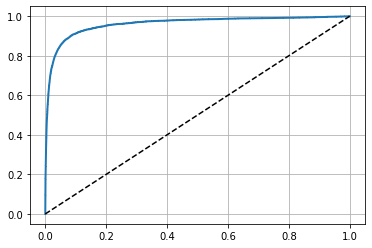

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.grid()
    plt.plot([0,1], [0,1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifiier will have a ROC AUC equal to 1.

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba', n_jobs=8)

**predict_proba** is methor returns a matrix containing a row per instance and a column for class, each containing the probability that given instance belongs to the given class.

In [41]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [42]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

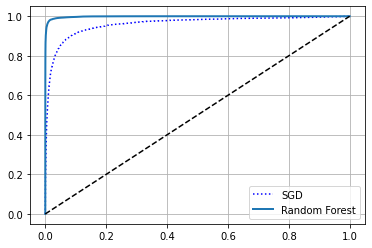

In [43]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1) # with usual method 

In [46]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification

- *One-versus-the-rest strategy* (OvR) or One-versus-all.
- *One-Versus-One* (OvO). It distinguishes a class between another class. It needs $ N \times (N - 1 ) / 2 $ classifiers.

With some algoritms (SVM) which does not scale with large training sets, it is better OvO,because it is faster to train, as the training sets are splits. For most binary classification algorithms, OvR is preferred.

In [48]:
from sklearn.svm import SVC
svm_clf = SVC() # It uses OvO because its algorithm is slooooooooooooow
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

SciKit-Learn will use OvO strategy. It trained 45 binary classifiers, got their decision scores for the image and selected the class that won the most duels.

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [51]:
np.argmax(some_digit_scores)

5

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [53]:
svm_clf.classes_[5]

5

In [55]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(), n_jobs=-1)
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
len(ovr_clf.estimators_)

10

In [57]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [58]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

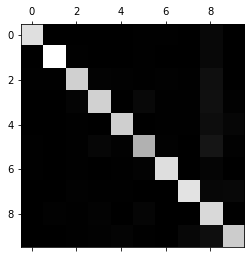

In [62]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

5 got a little mess

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

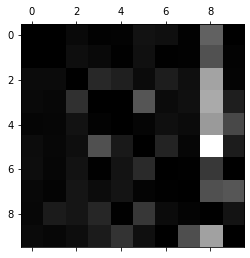

In [65]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

As you can see, many images get misclassified as 8. However, the row for class 8 is not that bad.

The two left blocs are digits classified as 3, the two right blocks are digits classified as 5.

In [66]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

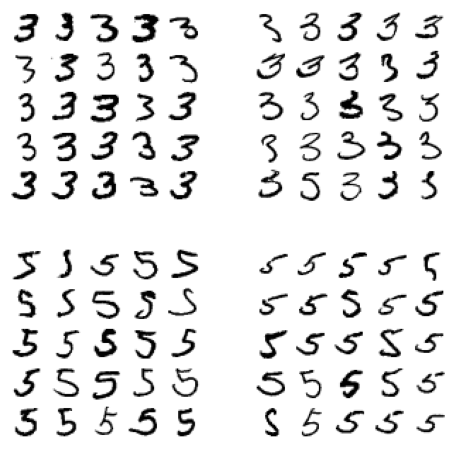

In [67]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [70]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=-1)

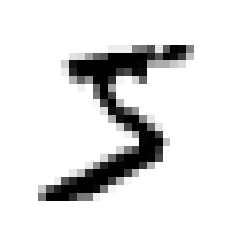

In [71]:
plot_digits([some_digit])

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [73]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

If you would like to make the score weighted depending on the predicted labels, you can simply sat average="weighted" and give each label a weight equal to its support

## Multioutput Classification

In [74]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [75]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

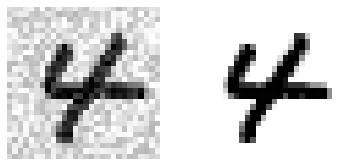

In [79]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [77]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(n_jobs=-1)

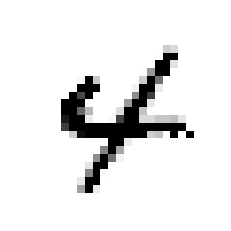

In [81]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercices

## Ex 1
### Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the *KNeighborsClassifier* works well for this task: you just need to find good hyperparameter values,

In [82]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
param_grid = [
    {
        'weights': ["uniform", "distance"],
        'n_neighbors': [3, 5]
    }
]

knn_clf = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn_clf, param_grid, cv=3, n_jobs=-1, verbose=3)
grid_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed: 25.9min remaining: 25.9min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 26.7min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [ ]:
import joblib

joblib.dump(grid_search_knn.best_estimator_, 'knn_class.pkl')

In [4]:
import joblib

In [6]:
knn_clf = joblib.load('03models/knn_class.pkl')

In [8]:
grid_search_knn.best_params_

NameError: name 'grid_search_knn' is not defined

In [85]:
grid_search_knn.best_score_

0.9693333333333333

In [19]:
y_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(X_test, y_pred)

In [ ]:
from sklearn.metrics import recall_score
recall_score(X_test, y_pred)

## Ex 2
### Write a function that can shift a MNIST image in any direction by one pixel. Then, for each imagen in the training set, create four shifted copies and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. This technique of growing the training set is called *data augmentation* or *training expansion*.

In [ ]:
from scipy.ndimage.interpolation import shift